<a href="https://colab.research.google.com/github/zdzichumis/Object-tracking-code/blob/main/Analiza%20wyniki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [2]:
def check_if_inside(point, bbox):
    bx0, by0, bx1, by1 = bbox
    x, y = point
    return (bx0 <= x <= bx1) and (by0 <= y <= by1)

In [7]:
tracking_bbox = pd.read_csv("track_04_30_18h_18_acceleration.csv")
#true_points = pd.read_csv("tagged2min_04_30_18h_18.csv")
true_points = pd.read_csv("interpolated2min_04_30_18h_18.csv")
#tracking_bbox = tracking_bbox[tracking_bbox["detected"] == 0].head()

## Ograniczanie danych

#### do obszaru zainteresowania na czerwono

In [8]:
main_area = [(0,720), (75, 288), (166,243), (1015,200), (1082, 241),
(1207, 512), (1065, 720)]
top_area = [(972, 390), (710, 310), (1135, 116), (1205, 161)]
bottom_area = [(1,661),(377,450),(807, 589),(640,719), (0,720)]
left_area = [(397,450),(591,337), (0,149), (1,293)]
right_area = [(755,598),(971,390), (1270, 505), (1259,684)]

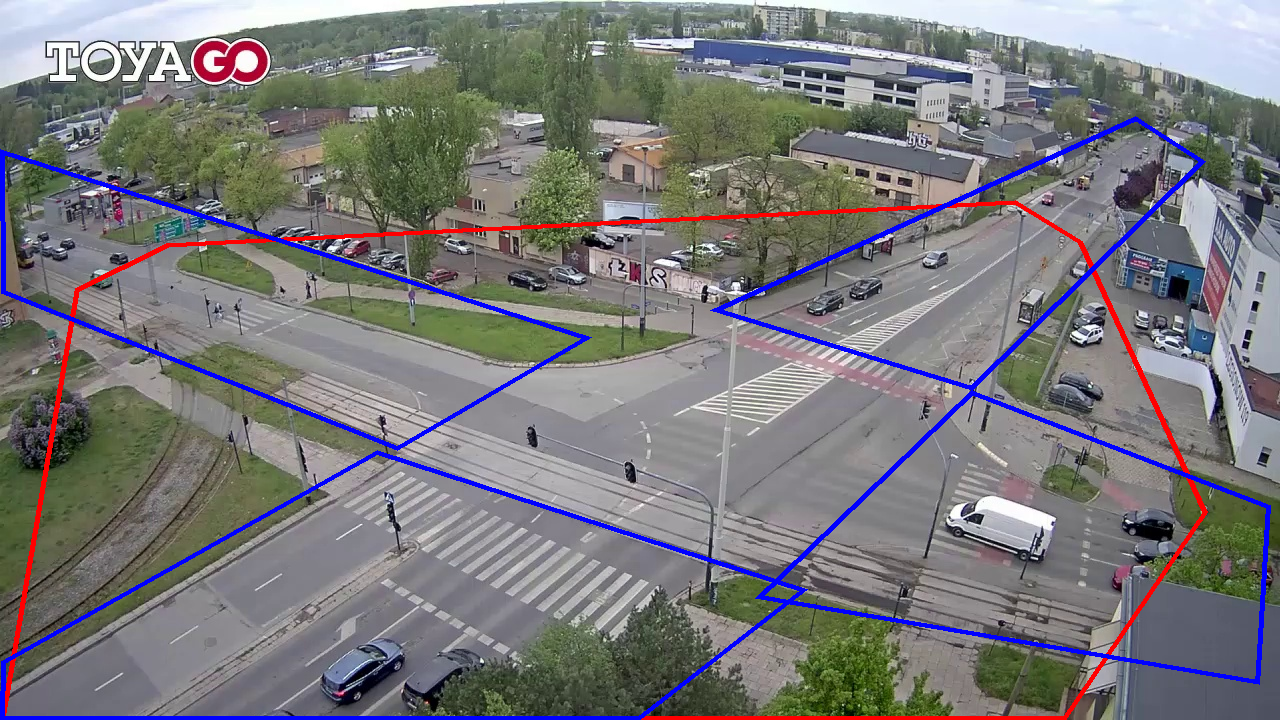

In [9]:
img = Image.open("reference.jpg")
img1 = ImageDraw.Draw(img)
img1.polygon(main_area, outline ="red", width=5)
img1.polygon(bottom_area, outline ="blue", width=5)
img1.polygon(top_area, outline ="blue", width=5)
img1.polygon(left_area, outline ="blue", width=5)
img1.polygon(right_area, outline ="blue", width=5)
img

$$ta+(1-t)b = (c_x, \cdot)$$

$$b+t(a-b) = (c_x, \cdot)$$

$$t^\ast = \frac{c_x-b_x}{a_x-b_x}, \ t^\ast(a-b) + b > c_y$$

In [10]:
def is_inner(px,py, polygon=main_area, verbose=False):
    points = polygon + [polygon[0]]
    counter = 0
    for a,b in zip(points, points[1:]):
        ax, ay = a
        bx, by = b
        ax, ay, bx, by = ax + 0.1, ay + 0.1, bx + 0.1, by + 0.1
        t = (px - bx)/(ax - bx)
        if 0 <= t < 1 and t * (ay - by) + by >= py:
            counter += 1
        if verbose:
            print(a, b, t)
    if verbose:
        print(counter)
    return (counter % 2) != 0


In [11]:
#####
#####  TAKES TRUE POINTS ONLY FROM INSIDE THE AREA OF INTEREST
#####

true_points = true_points[true_points.apply(lambda row: is_inner(row["x"], row["y"]), axis=1)]

#### do pierwszych dwóch minut

In [12]:
#####
#####  TAKES ONLY FRAMES FROM THE FIRST TWO MINUTES
#####

true_points = true_points[true_points["frame"] <= 30*60*2]
tracking_bbox = tracking_bbox[tracking_bbox["frame"] <= 30*60*2]

## Dodanie informacji o kierunku ruchu

 BRAK JESZCZE INFORMACJI O ZWROCIE, czyli do `BL` zaliczam samochody jadące z dołu w lewo, albo jadące z lewej strony w dół.

In [13]:
directions = []
for label, data in true_points.groupby("label"):
    for name, area in [("L", left_area), ("R", right_area), ("B", bottom_area), ("T", top_area)]:
        data[f"{name}"] = data.apply(lambda row: is_inner(row["x"], row["y"], area), axis=1)
    path_type = "".join([t for t, b in data[["L","R","B","T"]].any().items() if b])
    directions.append((label, path_type))
directions = pd.DataFrame(directions, columns = ["label", "path type"])

In [14]:
directions["path type"].value_counts()

,count
path type,
BT,16
LB,12
LR,9
B,3
LT,3
RT,1
RB,1
L,1
R,1


In [15]:
true_points = pd.merge(directions, true_points, on="label")

In [16]:
true_points

,label,path type,x,y,frame
0,0,BT,962,261,0
1,0,BT,949,269,15
2,0,BT,931,278,30
3,0,BT,917,284,45
4,0,BT,903,290,60
...,...,...,...,...,...
40746,46,B,237,688,3595
40747,46,B,237,688,3596
40748,46,B,237,688,3597
40749,46,B,237,688,3598


### sprawdzenie jak wyglądają typy trajektorii

In [17]:
def check_path(points):
    plt.title("true points")
    plt.scatter(points["x"], (-1)*points["y"], s=1)
    for polygon in [left_area, right_area, bottom_area, top_area]:
        area = np.array(polygon + [polygon[0]])
        plt.plot(area[:, 0], -area[:, 1], color="green")
    plt.xlim(0, 1280)
    plt.ylim(-720,-150)

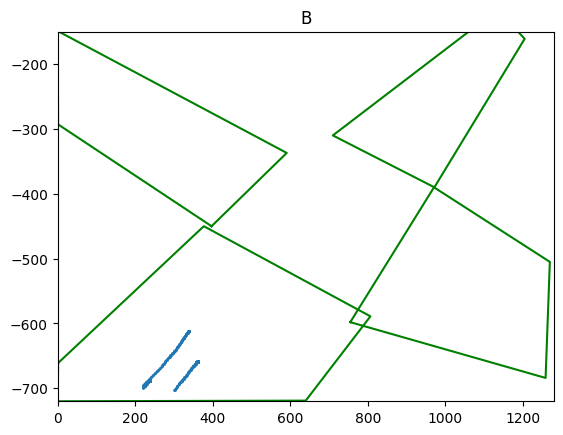

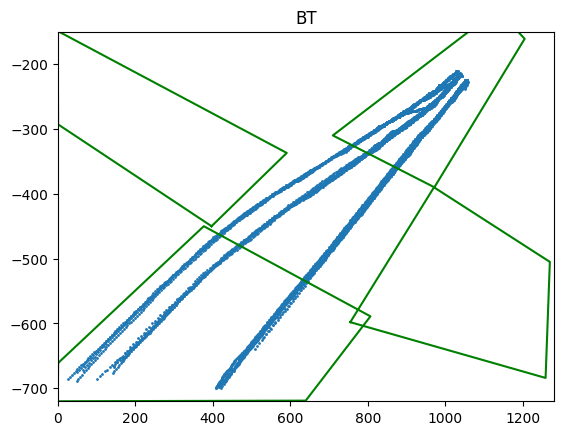

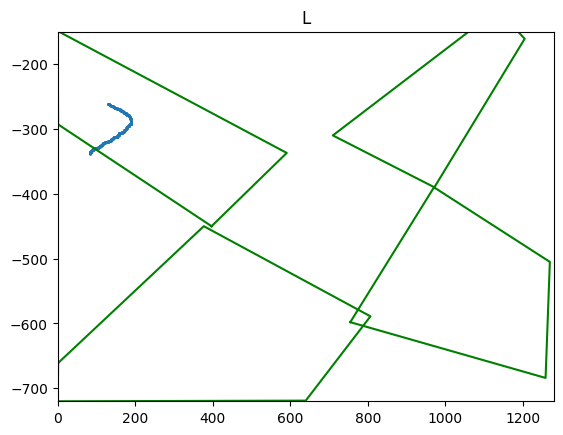

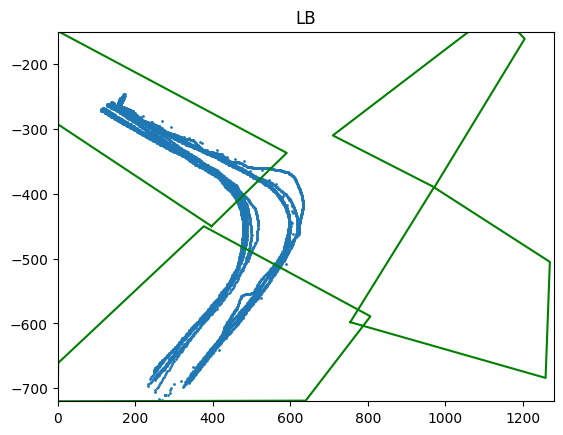

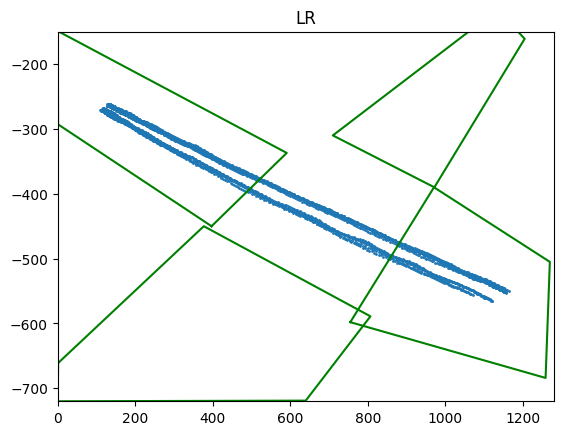

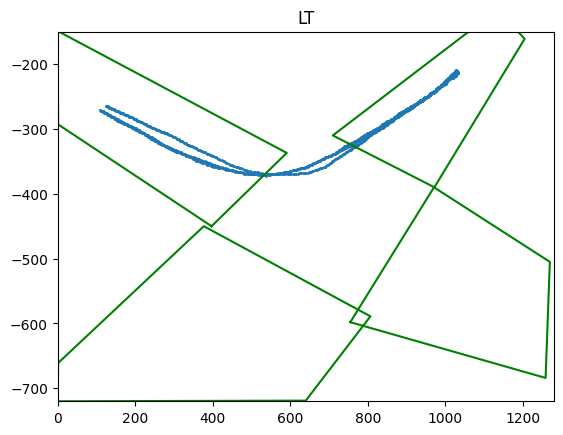

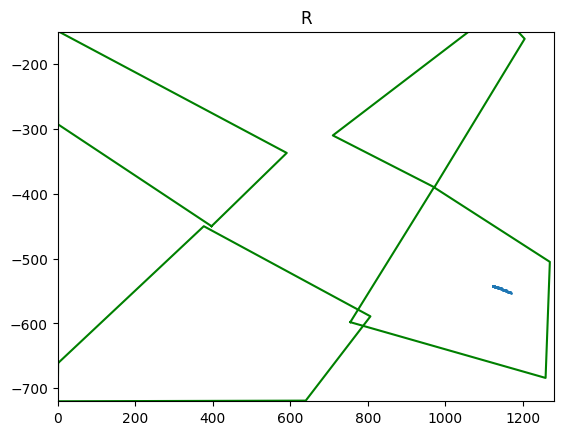

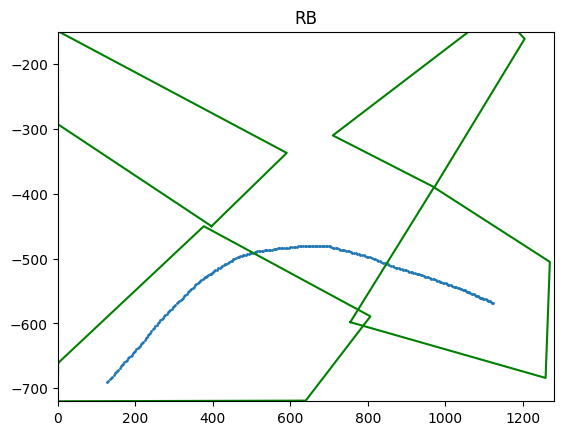

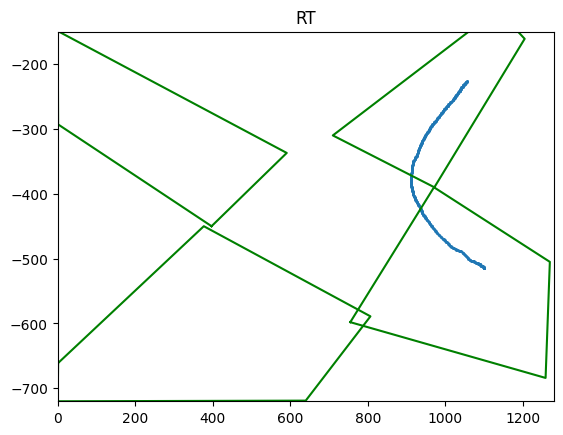

In [18]:
for _path_type, _data  in true_points.groupby("path type"):
    check_path(_data)
    plt.title(_path_type)
    plt.show()

## Obliczenie metryk poprawności śledzenia

In [19]:
#calculate if point is inside a bbox
#(the true points are not always perfectly on the car, so I use `eps` to be more forgiving)
matching = pd.merge(true_points, tracking_bbox, on="frame", suffixes=("_true", "_pred"))
match_x = ((matching["x0"] <= matching["x"]) & (matching["x"] <= matching["x1"] ))
match_y = ((matching["y0"] <= matching["y"]) & (matching["y"] <= matching["y1"]))
matching = matching[match_x & match_y]
matched = matching.copy().drop(columns=["x0","y0","x1", "y1"])

Definicje metryk:
 * `(%) matches best` - jaka część punktów pojazdu została przydzielona do obiektu (ze śledzenia), przy czym wybieramy obiekt dla któego ta część jak największa. Metryka powinna być jak największa, ale nie musi być 100%, bo brak detekcji samochodu również ma na nią wpływ.
 * `(%) matches 2nd best` - tak samo jak wyżej, tylko biorę drugi najlepszy obiekt. Metryka powinny być jak najmniejsza. Brak detekcji samochodu nie wypływa negatywnie na metrykę.
 * `(%) nondominant matches` -  podobnie jak `(%) matches best` tylko sumuje metryki dla wszystkich obiektów innych niż najlepszy (tzn. inne niż te używane w `(%) matches best`).

In [20]:
def check_true_object_i(label_i):
    points_count = true_points["label"].value_counts()[label_i]
    time_matched = matched[matched["label_true"]== label_i]["label_pred"].value_counts()/points_count*100
    remaining = 0
    if len(time_matched) > 0:
        remaining = time_matched.sum() - float(time_matched.head(1))
    time_matched = time_matched.head(2)
    return (list(time_matched) + [0, 0])[:2] + [remaining]
object_metrics = pd.DataFrame([check_true_object_i(y) + [y]
                           for y in true_points["label"].unique()],
            columns = ["(%) matches best", "(%) matches 2nd best", "(%) nondominant matches", "true_object_id"])
object_metrics = pd.merge(object_metrics, directions, left_on="true_object_id", right_on="label")
object_metrics = object_metrics.drop(columns =["label"])
object_metrics.head(5)


<ipython-input-20-9930f4598329>:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  remaining = time_matched.sum() - float(time_matched.head(1))


,(%) matches best,(%) matches 2nd best,(%) nondominant matches,true_object_id,path type
0,38.492222,35.061827,124.890307,0,BT
1,73.595944,13.533541,27.184087,1,BT
2,80.905146,9.175449,9.485431,2,RT
3,49.309912,22.584693,48.808030,3,LB
4,39.092873,37.796976,45.572354,4,LB


In [21]:
object_metrics

,(%) matches best,(%) matches 2nd best,(%) nondominant matches,true_object_id,path type
0,38.492222,35.061827,124.890307,0,BT
1,73.595944,13.533541,27.184087,1,BT
2,80.905146,9.175449,9.485431,2,RT
3,49.309912,22.584693,48.808030,3,LB
4,39.092873,37.796976,45.572354,4,LB
5,53.980583,39.223301,39.611650,5,LB
6,31.571219,1.321586,1.321586,6,LR
7,42.302772,27.547974,105.842217,7,BT
8,73.111782,38.368580,46.827795,8,LB
9,85.714286,15.406162,26.890756,9,LB


In [22]:
object_metrics.mean()

TypeError: Could not convert ['BTBTRTLBLBLBLRBTLBLBLBLBLBLBLBLBBTLBBTBBTBTLTBLRLTLRLRLRRBLRLRLLRLRBTBTBTRBTBTBTLTBTBTBTB'] to numeric

In [23]:
sorted_groups = sorted(object_metrics.groupby("path type"), key=lambda x: len(x[1]), reverse=True)
for _path_type, _data in sorted_groups:
    print(_path_type, f" count {len(_data)}")
    display(_data.mean())
    print("\n")

BT  count 16


TypeError: Could not convert ['BTBTBTBTBTBTBTBTBTBTBTBTBTBTBTBT'] to numeric

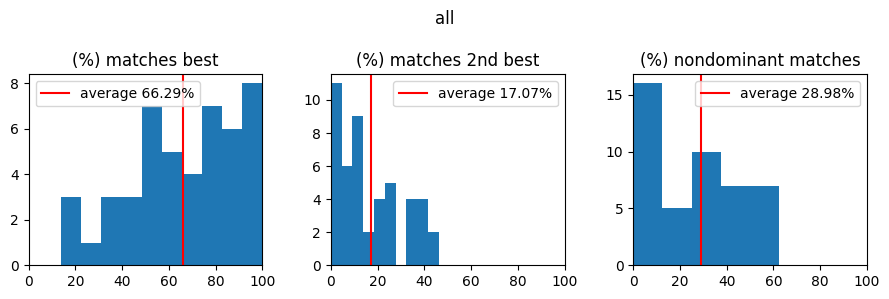

In [24]:
fig, axs = plt.subplots(1,3, figsize=(9,3))

fig.suptitle("all")
for i, col in enumerate(["(%) matches best", "(%) matches 2nd best", "(%) nondominant matches"]):
    axs[i].hist(object_metrics[col])
    avg =object_metrics[col].mean()
    axs[i].set_title(col)
    axs[i].axvline(x=avg, ymin=0, ymax=1, color="red", label=f"average {avg:.4}%")
    axs[i].set_xlim(0, 100)
    axs[i].legend()
plt.tight_layout()
plt.show()

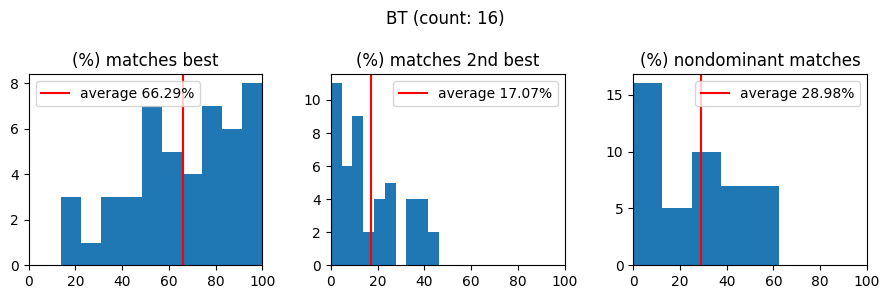

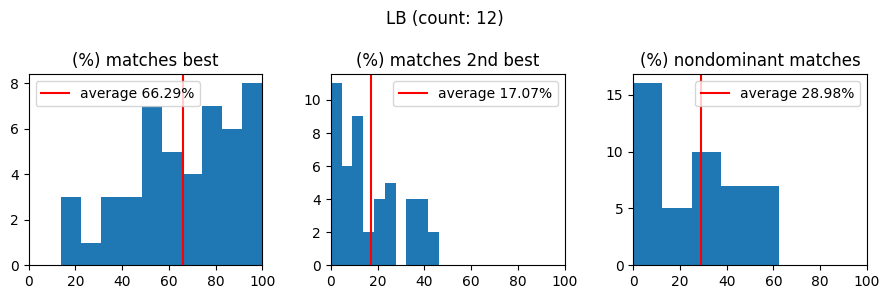

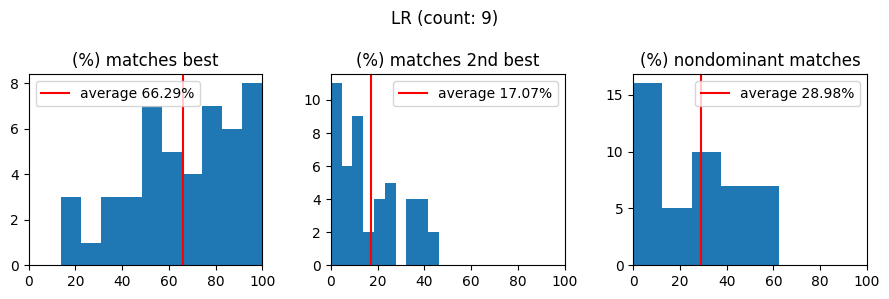

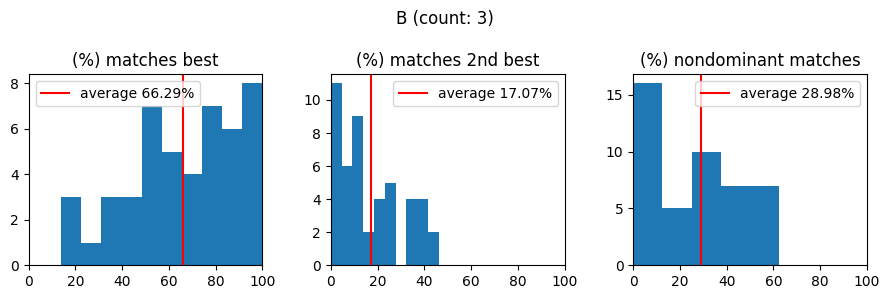

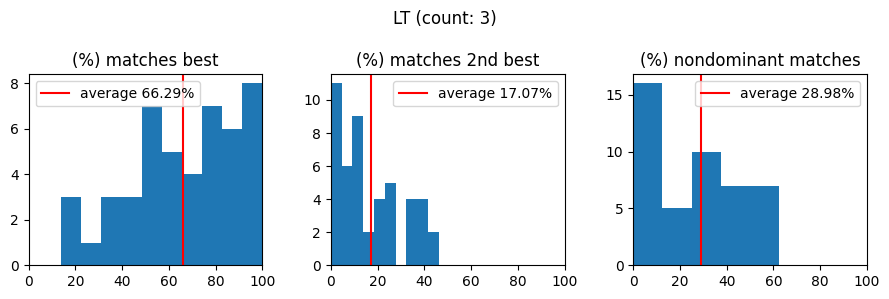

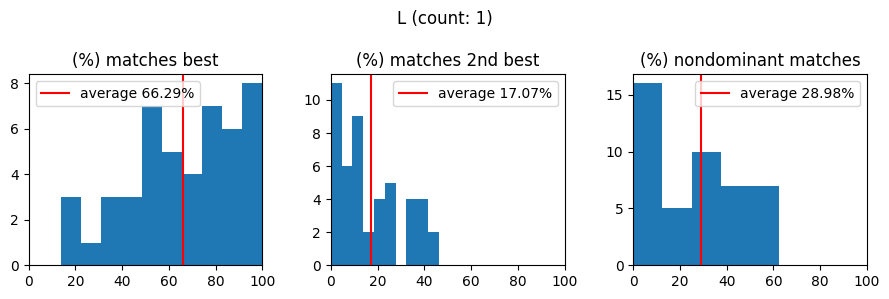

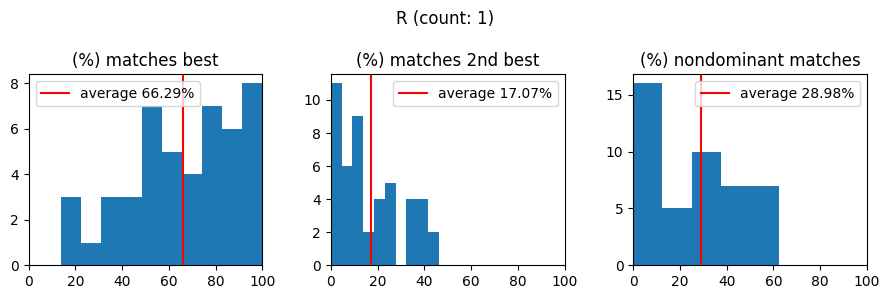

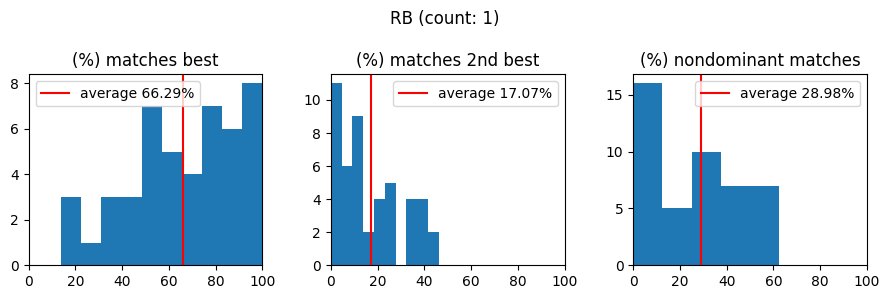

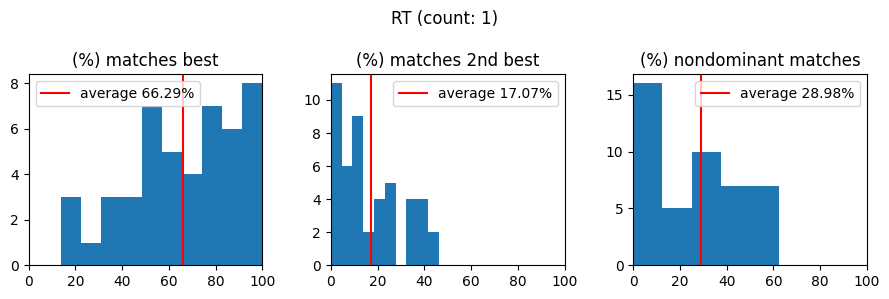

In [25]:
sorted_groups = sorted(object_metrics.groupby("path type"), key=lambda x: len(x[1]), reverse=True)
for _path_type, _data in sorted_groups:
    fig, axs = plt.subplots(1,3, figsize=(9,3))
    fig.suptitle(_path_type + f" (count: {len(_data)})")
    for i, col in enumerate(["(%) matches best", "(%) matches 2nd best", "(%) nondominant matches"]):
        axs[i].hist(object_metrics[col])
        avg =object_metrics[col].mean()
        axs[i].set_title(col)
        axs[i].axvline(x=avg, ymin=0, ymax=1, color="red", label=f"average {avg:.4}%")
        axs[i].set_xlim(0, 100)
        axs[i].legend()
    plt.tight_layout()
    plt.show()

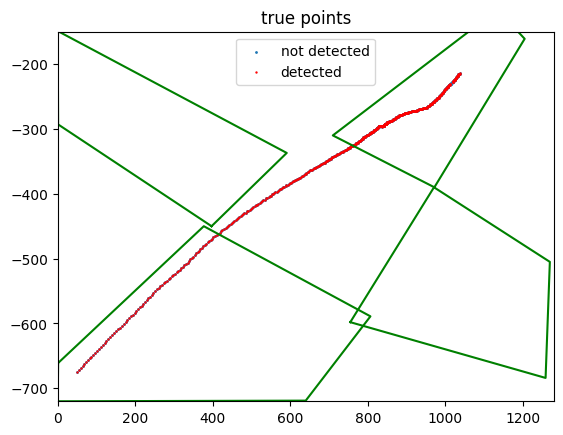

In [26]:

def check(tp, match):
    plt.title("true points")
    plt.scatter(tp["x"], (-1)*tp["y"], s=1, label="not detected")
    plt.scatter(match["x"], (-1)*match["y"], s=0.5, color="red", label="detected")
    for polygon in [left_area, right_area, bottom_area, top_area]:
        area = np.array(polygon + [polygon[0]])
        plt.plot(area[:, 0], -area[:, 1], color="green")
    plt.xlim(0, 1280)
    plt.ylim(-720,-150)
    plt.legend()
#check(true_points, matching)

check(true_points[true_points["label"] == 7],
      matching[matching["label_true"] == 7])